In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed
import tensorflow as tf
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import *
import image_utils as iu
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
data_path = 'data'


In [4]:
train_data_path = os.path.join(data_path, 'fruits', 'train')
val_data_path = os.path.join(data_path, 'fruits', 'val')


In [5]:
train_images_path = iu.get_all_files(train_data_path)
val_images_path = iu.get_all_files(val_data_path)

In [6]:
train_images = []
val_images = []

for x in range(len(train_images_path)):
    # try:
    train_images.append(iu.read_image(os.path.join(train_data_path, train_images_path[x]), 'RGB'))
    # except:
    #     pass

for x in range(len(val_images_path)):
    try:
       val_images.append(iu.read_image(os.path.join(
           val_data_path, val_images_path[x]), 'RGB'))
    except:
       pass


In [7]:
print('train size:', len(train_images))
print('val size:', len(val_images))


train size: 67692
val size: 22688


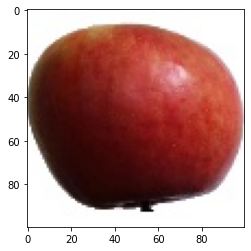

In [8]:
iu.display_image(train_images[0])

In [9]:
new_dimen = 96
# resize the image. The aspect ratio of the image is maintained.
for x in range(len(train_images)):
    new_width, new_height = iu.get_new_image_dimen(train_images[x], new_dimen)
    # resize(images[x], new_width, new_height)
    train_images[x] = train_images[x].resize((int(new_width), int(new_height)))

# resize the image. The aspect ratio of the image is maintained.
for x in range(len(val_images)):
    new_width, new_height = iu.get_new_image_dimen(val_images[x], new_dimen)
    # resize(images[x], new_width, new_height)
    val_images[x] = val_images[x].resize((int(new_width), int(new_height)))


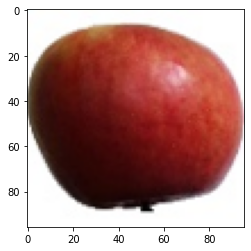

In [10]:
# display resized image
iu.display_image(train_images[0])

In [11]:
#images are converted to numpy arrays to be padded.
for x in range(len(train_images)):
    train_images[x] = np.asarray(train_images[x])

for x in range(len(val_images)):
    val_images[x] = np.asarray(val_images[x])

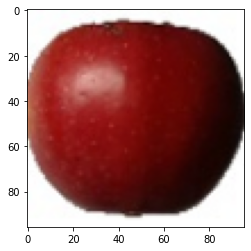

In [12]:
# display resized image
iu.display_image(val_images[0])


In [18]:
# since the images do not have the same aspect ratios,
# the image is padded to have the same aspect ratios. 
for x in range(len(train_images)):
    train_images[x] = iu.pad_image(train_images[x], new_dimen)

for x in range(len(val_images)):
    val_images[x] = iu.pad_image(val_images[x], new_dimen)


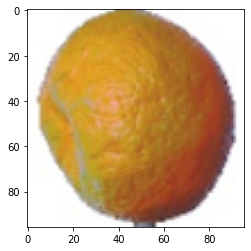

In [13]:
# display padded image
iu.display_image(val_images[1])

In [14]:
def convert_np_rgb_image_to_ycbcr(image):
    return Image.fromarray(image).convert('YCbCr')


In [15]:
def get_y_channel_from_ycbcr(ycbcr_image):
    return np.asarray(ycbcr_image.getchannel('Y'))


In [16]:
def get_cbcr_channel_from_ycbcr(ycbcr_image: Image):
    (y, cb, cr) = ycbcr_image.split()
    return np.asarray(Image.merge('CbCr', (cb, cr)))


In [17]:
def get_y_channel(image):
    return image[:, :, 0]


In [17]:
# def get_cbcr_channel(image):
#     new_im = [None] * image.shape[0]
#     for r in range(image.shape[0]):
#         row = image[r]
#         new_row = [None] * row.shape[0]
#         for p in range(row.shape[0]):
#             new_row[p] = [row[p][1], row[p][2]]
#         new_im[r] = new_row
#     return np.array(new_im)


In [34]:
def combine_y_to_cbcr_channel(y_image, cbcr_image):
    new_im = [None] * y_image.shape[0]
    for r in range(y_image.shape[0]):
        row_y = y_image[r]
        row_cbcr = cbcr_image[r]
        new_row = [None] * row_y.shape[0]
        for p in range(row_y.shape[0]):
            new_row[p] = [row_y[p][0], row_cbcr[p][0], row_cbcr[p][1]]
        new_im[r] = new_row
    return np.array(new_im)


In [18]:
def get_cbcr_channel(image):
    cb_channel = image[:, :, 1]
    cr_channel = image[:, :, 2]
    cb_cr = np.empty(shape=(image.shape[0], image.shape[1], 2))
    cb_cr[:,:, 0] = cb_channel
    cb_cr[:,:, 1] = cr_channel
    return np.array(cb_cr)


In [19]:
train_images[0].shape


(96, 96, 3)

In [20]:
# rgb np array is converted ycbcr color space
for x in range(len(train_images)):
    train_images[x] = iu.rgb2ycbcr(train_images[x]);

for x in range(len(val_images)):
    val_images[x] = iu.rgb2ycbcr(val_images[x])


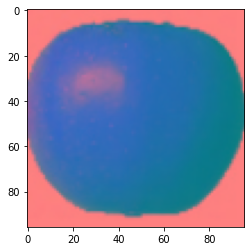

In [21]:
# display ycbcr image
iu.display_image(val_images[0])


In [22]:
train_images_y_channel = [None] * len(train_images)
val_images_y_channel = [None] * len(val_images)
# y channel is extracted from the ycbcr color space
for x in range(len(train_images)):
    train_images_y_channel[x] = get_y_channel(train_images[x])


for x in range(len(val_images)):
    val_images_y_channel[x] = get_y_channel(val_images[x])


In [23]:
train_images_cb_cr_channel = [None] * len(train_images)
val_images_cb_cr_channel = [None] * len(val_images)
for x in range(len(train_images)):
    train_images_cb_cr_channel[x] = get_cbcr_channel(train_images[x])

for x in range(len(val_images)):
    val_images_cb_cr_channel[x] = get_cbcr_channel(val_images[x])


In [24]:
train_images = None
val_images = None

In [25]:
train_images_cb_cr_channel = np.array((train_images_cb_cr_channel)) / 255
train_images_y_channel = np.array(train_images_y_channel) / 255

val_images_cb_cr_channel = np.array((val_images_cb_cr_channel)) / 255
val_images_y_channel = np.array(val_images_y_channel) / 255


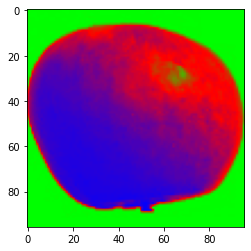

In [26]:
iu.display_image(train_images_y_channel[0])

In [63]:

#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 120, 120, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 512)       1180

In [340]:
#Encoder
encoder_input = Input(shape=(240, 240, 1,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)

encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)

encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((4, 4))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((3, 3))(decoder_output)
decoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((5, 5))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 240, 240, 1)]     0         
                                                                 
 conv2d_271 (Conv2D)         (None, 120, 120, 64)      640       
                                                                 
 conv2d_272 (Conv2D)         (None, 120, 120, 128)     73856     
                                                                 
 conv2d_273 (Conv2D)         (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 30, 30, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_274 (Conv2D)         (None, 30, 30, 256)       295168    
                                                          

In [28]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection


def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [29]:
input_size = (new_dimen, new_dimen, 1)
n_filters = 32
n_classes = 2

# Input size represent the size of 1 image (the size used for pre-processing)
inputs = Input(input_size)

# Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
# Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
cblock2 = EncoderMiniBlock(
    cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
cblock3 = EncoderMiniBlock(
    cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
cblock4 = EncoderMiniBlock(
    cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
cblock5 = EncoderMiniBlock(
    cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

# Decoder includes multiple mini blocks with decreasing number of filters
# Observe the skip connections from the encoder are given as input to the decoder
# Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

# Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
# Followed by a 1x1 Conv layer to get the image to the desired size.
# Observe the number of channels will be equal to number of output classes
conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock9)

conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=conv10)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


2022-04-22 14:35:27.180627: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 32)  128         ['conv2d_1[0][0]']               
 alization)                                                                                   

Transfer Learning with VGG16

In [1]:
from tensorflow.keras.initializers import RandomNormal


def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def define_decoder(inputs, skip_layer, num_filters):
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(num_filters, (2, 2), strides=(
        2, 2), padding='same', kernel_initializer=init)(inputs)
    g = Concatenate()([x, skip_layer])
    g = conv_block(g, num_filters)
    return g


In [4]:
vgg16 = VGG16(include_top=False, weights='imagenet')

2022-04-21 23:05:28.877060: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
def vgg16_unet(input, tensor):
    # inputs = Input(shape=input_shape)
    # We will extract encoder layers based on their output shape from vgg16 model
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=tensor)
    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    # bottleneck/bridege layer from vgg16
    s4 = vgg16.get_layer('block4_conv3').output
    b1 = vgg16.get_layer('block5_conv3').output  # 32
    # Decoder Block
    d1 = define_decoder(b1, s4, 512)
    d2 = define_decoder(d1, s3, 256)
    d3 = define_decoder(d2, s2, 128)
    d4 = define_decoder(d3, s1, 64)  # output layer
    outputs = Conv2D(2, 1, padding='same', activation='sigmoid')(d4)
    model = Model(input, outputs)
    return model


In [45]:
input_size = (new_dimen, new_dimen, 1)
img_input = Input(shape=input_size)
img_conc = Concatenate()([img_input, img_input, img_input])
model = vgg16_unet(img_input,tensor=img_conc)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_17 (Concatenate)   (None, 240, 240, 3)  0           ['input_9[0][0]',                
                                                                  'input_9[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 240, 240, 64  1792        ['concatenate_17[0][0]']   

In [47]:
train_images_y_channel.shape

(7371, 320, 320)

In [50]:
val_images_cb_cr_channel.shape

(818, 320, 320, 2)

In [87]:
def show_predictions(path):
    test_image = iu.read_image(
        path, 'RGB')
    # resize image
    new_width, new_height = iu.get_new_image_dimen(test_image, new_dimen)
    test_image = test_image.resize((int(new_width), int(new_height)))
    test_image = np.asarray(test_image)
    # pad image
    test_image = iu.pad_image(test_image, new_dimen)
    # rgb np array is converted ycbcr color space
    test_image = iu.rgb2ycbcr(test_image)
    test_image = get_y_channel(test_image) / 255
    output = model.predict(np.array([test_image]))
    cbcr_image = output[0] * 255
    test_image = test_image.reshape(new_dimen, new_dimen, 1)
    test_image = test_image * 255
    ycbcr_image = combine_y_to_cbcr_channel(test_image, cbcr_image)
    rgb_image = iu.ycbcr2rgb(ycbcr_image)
    iu.display_image(rgb_image)


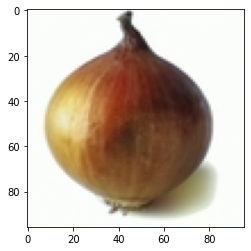

In [93]:
show_predictions(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/fruits/bw13.jpg')


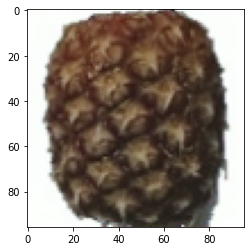

In [92]:
show_predictions(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/fruits/val/9_100 39.jpg')


In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          try:
             show_predictions()
          except:
              pass
          print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/2
2116/2116 [==============================] - ETA: 0s - loss: 4.5707e-04 - accuracy: 0.7907
Sample Prediction after epoch 1

2116/2116 [==============================] - 8503s 4s/step - loss: 4.5707e-04 - accuracy: 0.7907 - val_loss: 4.8304e-04 - val_accuracy: 0.8632
Epoch 2/2
2116/2116 [==============================] - ETA: 0s - loss: 3.4498e-04 - accuracy: 0.7971
Sample Prediction after epoch 2

2116/2116 [==============================] - 8302s 4s/step - loss: 3.4498e-04 - accuracy: 0.7971 - val_loss: 3.9995e-04 - val_accuracy: 0.8551


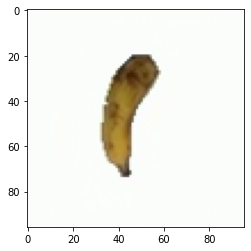

In [72]:
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(train_images_y_channel, train_images_cb_cr_channel, validation_data=(
    val_images_y_channel, val_images_cb_cr_channel), callbacks=[DisplayCallback()], epochs=2)


In [94]:
model.save("saved_model")

2022-04-23 00:16:37.294582: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


In [95]:
model.save('auto_color_fruit_model.h5')


In [72]:
y_image = train_images_y_channel[100]
output = model.predict(np.array([y_image]))


/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/ml-env/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [75]:
y_image

array([[[0.23137255],
        [0.25098039],
        [0.2745098 ],
        ...,
        [0.21960784],
        [0.22352941],
        [0.22745098]],

       [[0.21568627],
        [0.23137255],
        [0.25882353],
        ...,
        [0.25882353],
        [0.25098039],
        [0.24705882]],

       [[0.22352941],
        [0.23921569],
        [0.25882353],
        ...,
        [0.29019608],
        [0.27843137],
        [0.27058824]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [74]:
y_image = y_image.reshape(320,320,1)

In [64]:
ycbcr_image = output[0] * 255


In [59]:
rgb = iu.ycbcr2rgb(ycbcr_image)

IndexError: index 2 is out of bounds for axis 2 with size 2

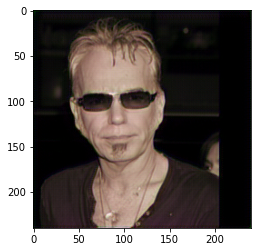

In [74]:
iu.display_image(rgb)

In [76]:
cbcr_image = output[0] * 255
y_image = y_image * 255
ycbcr_image = combine_y_to_cbcr_channel(y_image,cbcr_image)


In [77]:
y_image

array([[[59.],
        [64.],
        [70.],
        ...,
        [56.],
        [57.],
        [58.]],

       [[55.],
        [59.],
        [66.],
        ...,
        [66.],
        [64.],
        [63.]],

       [[57.],
        [61.],
        [66.],
        ...,
        [74.],
        [71.],
        [69.]],

       ...,

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]])

In [78]:
ycbcr_image


array([[[ 59.        , 108.17695618, 129.33380127],
        [ 64.        , 110.52877045, 129.87155151],
        [ 70.        , 117.42589569, 131.55038452],
        ...,
        [ 56.        , 116.5171051 , 121.01493073],
        [ 57.        , 118.18214417, 112.64983368],
        [ 58.        ,  82.17501068,  80.82606506]],

       [[ 55.        , 113.25300598, 126.45350647],
        [ 59.        , 120.82111359, 120.43052673],
        [ 66.        , 120.29764557, 128.69978333],
        ...,
        [ 66.        , 118.22068024, 123.1701355 ],
        [ 64.        , 114.2861557 , 132.38615417],
        [ 63.        , 103.32776642, 107.53494263]],

       [[ 57.        , 117.27497101, 130.55081177],
        [ 61.        , 122.02935028, 123.58957672],
        [ 66.        , 119.04573822, 127.3571701 ],
        ...,
        [ 74.        , 116.60624695, 128.80406189],
        [ 71.        , 115.51560974, 127.56233215],
        [ 69.        , 114.01035309, 126.7707901 ]],

       ...,

      

In [79]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)


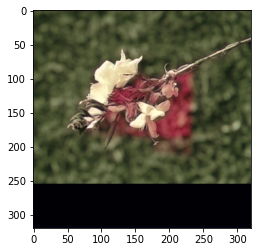

In [80]:
iu.display_image(rgb_image)

In [182]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:, :, [1, 2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


In [310]:
image = output[0] * 255
rgb_image =ycbcr2rgb(image)


/var/folders/kh/ldlc522d21lbvxg7zwz8yh8r0000gn/T/ipykernel_67439/1384511715.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


In [94]:
#test image
test_image = iu.read_image(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/flower_data/rose2.jpeg', 'RGB')


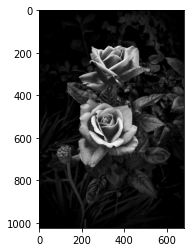

In [95]:
iu.display_image(test_image)


In [96]:
# resize image
new_width, new_height = iu.get_new_image_dimen(test_image, new_dimen)
test_image = test_image.resize((int(new_width), int(new_height)))


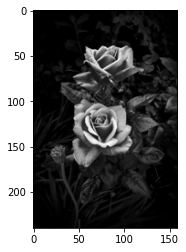

In [97]:
iu.display_image(test_image)


In [98]:
test_image = np.asarray(test_image)


In [99]:
# pad image
test_image = iu.pad_image(test_image, 240)


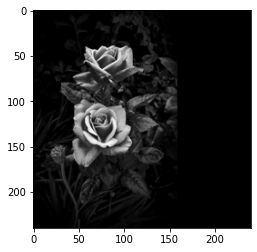

In [100]:
iu.display_image(test_image)


In [101]:
# rgb np array is converted ycbcr color space
test_image = iu.rgb2ycbcr(test_image)


In [102]:
test_image = get_y_channel(test_image)


In [84]:
test_image.shape

(240, 240)

In [103]:
test_image = test_image / 255


In [104]:
output = model.predict(np.array([test_image]))

In [105]:
ycbcr_image = output[0]
ycbcr_image = ycbcr_image * 255

In [106]:
cbcr_image = get_cbcr_channel(ycbcr_image)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [107]:
cbcr_image = ycbcr_image

In [108]:
test_image = test_image.reshape(new_dimen, new_dimen, 1)
test_image = test_image * 255

In [109]:
# test_cbcr_image = output[0] * 255
# # y_image = y_image * 255
# test_image = test_image * 255
ycbcr_image = combine_y_to_cbcr_channel(test_image, cbcr_image)

In [110]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)

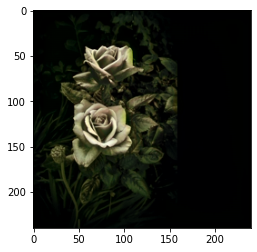

In [111]:
iu.display_image(rgb_image)
